## Qiita  Titanic 記事を参考にやってみた
### [タイタニック号乗客の生存予測モデルを立ててみる](https://qiita.com/suzumi/items/8ce18bc90c942663d1e6)
---

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv('../data/train.csv')
train.Sex = train.Sex.replace(['male','female'],[0,1]) #性別が扱いづらいので男性0、女性1とする

In [4]:
# 欠損値の扱い
train["Age"].fillna(train.Age.median(), inplace = True)

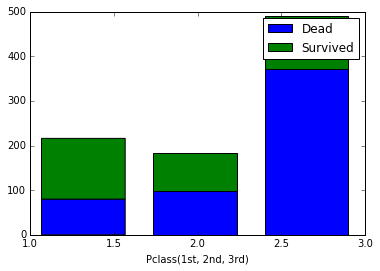

In [5]:
# 客室ごとのグレードごとにヒストグラム出力
split_data = []
for survived in [0,1]:
    split_data.append(train[train.Survived == survived])
    
temp = [i["Pclass"].dropna() for i in split_data]
plt.xlabel("Pclass(1st, 2nd, 3rd)")
labels = ["Dead", "Survived"]
plt.hist(temp, histtype="barstacked", bins=3, width = 0.5, label = labels)
plt.legend()

左から一等、二頭、三等でオレンジが生存した人、ブルーが死亡した人の割合が出ている
等級が上であるほど生存している割合が高い


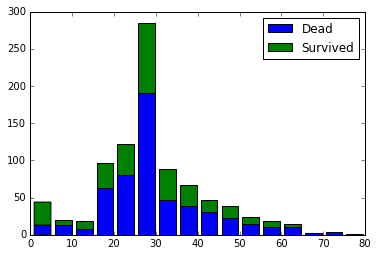

In [6]:
temp = [i["Age"].dropna() for i in split_data]
labels = ["Dead", "Survived"]
plt.hist(temp, histtype="barstacked", bins=16, width = 4.0, label = labels)
plt.legend()

Ageの欠損値を中央値でおいたため真ん中の突出が大きい

In [7]:
#年齢が欠損しているデータを除外したデータフレームを作成
train_ex_misval = pd.read_csv('../data/train.csv')
train_ex_misval = train_ex_misval.dropna()
train_ex_misval.Sex = train_ex_misval.Sex.replace(['male','female'],[0,1])

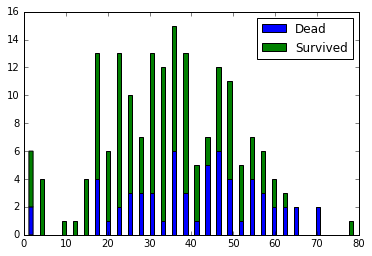

In [16]:
split_data_ex = []
for survived in [0,1]:
    split_data_ex.append(train_ex_misval[train_ex_misval.Survived == survived])
temp = [i["Age"].dropna() for i in split_data_ex]
labels = ["Dead", "Survived"]
plt.hist(temp, histtype="barstacked", bins=16, width = 4, label = labels)
plt.legend()

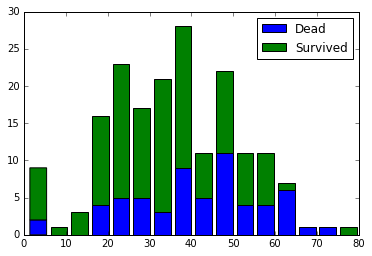

In [9]:
split_data_ex = []
for survived in [0,1]:
        split_data_ex.append(train_ex_misval[train_ex_misval.Survived == survived])

temp = [i["Age"].dropna() for i in split_data_ex]
labels = ["Dead", "Survived"]
plt.hist(temp, histtype="barstacked", bins=16, width = 4, label = labels)
plt.legend()

記事と少し結果が違うけど除外の仕方あってる？

- - -  
## ・データ整形
### 仮定: ５人以上の家族は生存率が低い？
### アプローチ: 家族の人数用の変数を用意して学習に利用

In [10]:
#新たなカラムFamilySizeを用意(Sibsp... 乗船している夫婦、兄弟姉妹の数, Parch...乗船している親、子供の数)
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
train_fm = train.drop(["Name", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"], axis=1)
print(train_fm)
train_fm.dtypes

     PassengerId  Survived  Pclass  Sex   Age  FamilySize
0              1         0       3    0  22.0           2
1              2         1       1    1  38.0           2
2              3         1       3    1  26.0           1
3              4         1       1    1  35.0           2
4              5         0       3    0  35.0           1
5              6         0       3    0  28.0           1
6              7         0       1    0  54.0           1
7              8         0       3    0   2.0           5
8              9         1       3    1  27.0           3
9             10         1       2    1  14.0           2
10            11         1       3    1   4.0           3
11            12         1       1    1  58.0           1
12            13         0       3    0  20.0           1
13            14         0       3    0  39.0           7
14            15         0       3    1  14.0           1
15            16         1       2    1  55.0           1
16            

PassengerId      int64
Survived         int64
Pclass           int64
Sex              int64
Age            float64
FamilySize       int64
dtype: object

---
# ・実際に学習させてみる
## アプローチ: 
### Python機械学習ライブラリのScikit-learn からRandomForestClassifierを使って決定木を作成し予測する
 学習データとして必要なのはPclass以降変数であるため分離する。
 生存結果であるSuevivedは正解データとする

In [11]:
train_data = train_fm.values
xs = train_data[:, 2:] #Pclass以降の変数
y = train_data[:, 1] #正解データ

実際に学習させて予測モデルを作る
そしてtesc.csvもtrain.csv同様に整形

In [12]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100) # 決定木の数: 100

#学習
forest = forest.fit(xs, y)

test_df = pd.read_csv("../data/test.csv").replace(["male","female"],[0,1])

#欠損値の補完
test_df["Age"].fillna(train.Age.median(), inplace=True)
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"] + 1
#test_df_arranged = test_df.drop(["Name", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"], axis=1)

In [13]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S,2
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q,1
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S,3


In [14]:
test_data = test_df_arranged.values
xs_test = test_data[:, 1:]
output = forest.predict(xs_test)

print(len(test_data[:,0]), len(output))
zip_data = zip(test_data[:,0].astype(int), output.astype(int))
predict_data = list(zip_data)

NameError: name 'test_df_arranged' is not defined

最後にリストをcsvに書き込み

In [ ]:
import csv
with open("../result/predict_result_qiita.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(test_data[:,0].astype(int), output.astype(int)):
        writer.writerow([pid, survived])

# ・結果
## 0.69856
---

In [ ]:
#dotファイルを出力
#from sklearn import tree
#for i,val in enumerate(forest.estimators_):
#    tree.export_graphviz(forest.estimators_[i], out_file='tree_%d.dot'%i)
# >dot -Tpng tree_0.dot -o tree.png

## ・treeの表示
<img src="tree.png">

### 決定木の数を変える

In [ ]:
forest = RandomForestClassifier(n_estimators = 10000) # 決定木の数: 100

#学習
forest = forest.fit(xs, y)

output = forest.predict(xs_test)

print(len(test_data[:,0]), len(output))
zip_data = zip(test_data[:,0].astype(int), output.astype(int))
predict_data = list(zip_data)

import csv
with open("../result/predict_result_qiitaP.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(test_data[:,0].astype(int), output.astype(int)):
        writer.writerow([pid, survived])

### 結果
* 50: 0.69856
* 100: 0.69856 
* 300: 0.69856
* 1000: 0.70813
* 10000: 0.70334

In [ ]:
# 72まであがるハイパーパラメータ
# forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=25, max_features='auto', max_leaf_nodes=None,
#             min_samples_leaf=1, min_samples_split=15,
#             min_weight_fraction_leaf=0.0, n_estimators=51, n_jobs=4,
#             oob_score=False, random_state=0, verbose=0, warm_start=False)